## Is artificial intelligence less than our intelligence? —Spike Jonze

This kernel has the been divided into following section
<br/>
* Introduction
* Data Loading in PyTorch
* Architecture of Capsule Network
* Loss function for Capsule Network
* Training the model


### Introduction - Capsule Networks
This kernel is a very elementary primer on Capsule network and implementing it using PyTorch. At the end of this tutorial, you will have hands on grash on capsule networks and pytorch. Capsnets reject the pooling layer strategy of conventional CNNs that reduces the amount of detail to be processed at the next higher layer.
**A capsule network takes input an image and finds ouoto what kind of object is present and what are the instatiation parameters(rotation, thickness, etc).**
* **Why capsule networks**
<br/>
Pooling allows a degree of translational invariance (it can recognize the same object in a somewhat different location) and allows a larger number of feature types to be represented. The main disadvantage of Pooling is that pooling can't explore the spatial relationship and provides invariance instead of equivariance i.e translation of input features results in an equivalent translation of outputs. In brief, CNN contains pooling layer which can't capture spatial relationship like poses of an entity. But capsule is designed in such a way that it can easily capture these features. The mathematical interpretation of invariance and equivariance is described below:

With a structure of a group G, g being one specific translation operator, A function or feature f is ***invariant*** under G if for all images in a class, and for any g
$$
f(g(I)) = f(I)
$$
whereas
A function or feature is ***equivariant*** under G is for all the images a class, there exists a unique **G'**
$$
f(g(I)) = g'(f(I))
$$

![](https://image.slidesharecdn.com/equivarianceinvariance-180201075728/95/brief-intro-invariance-and-equivariance-4-638.jpg?cb=1517472411 | width=50) 

![](https://image.slidesharecdn.com/equivarianceinvariance-180201075728/95/brief-intro-invariance-and-equivariance-6-638.jpg?cb=1517472411 | width=50)

**A capsule network is composed of many capsules. Let's peep into them.**
### CAPSULE
A capsule is a group of neurons whose activity vectors represent various instantiation parameters of an object. For classifying an entity to class, there should be an agreement between multiple capsules. Basically, this process goes like this:
* Active capsules at the lower level makes prediction for the instantiation parameters of higher level capsules.Tthe lower level capsules represents lower level features like presence of rectangle or triangle whereas the higher level features represents boat or house.
* When multiple capsules of a lower level come to an agreement, the capsules at higher level become active. Hence, capsule nets are able to establish a hierarchy of features between various levels of capsules. For eg, from an image of boat, capsnet can capture the presence of a triangle over a rectangle entity as a whole and as we move down the lower levels, it can capture features like presence of rectangle and a triangle.
* The probability of presence of entity is determined by the length of the activity vectors and the vector's orientation tells about the properties of an entity.


The length of the activity vector is fed into a non-linear transformation called the ***squashing function*** so that the length of output vector becomes less than 1 because it is used to represent probability .

<img src="https://cdn-images-1.medium.com/max/2000/1*RB03q9MINVgRPK_VBcBnsg.png" data-canonical-src="https://cdn-images-1.medium.com/max/2000/1*RB03q9MINVgRPK_VBcBnsg.png" width="500" height="400" />

The main component of capsule network is the **routing by agreement** strategy by which capsule of different levels interact with each other about which we will discuss in later sections.

In [1]:
import numpy as np
import pandas as pd
import torch.nn.functional as F
import pdb
from torch import nn
import math
from torch.optim import lr_scheduler
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
import torch
import itertools
import seaborn as sns
sns.set(style="darkgrid")
from torch.autograd import Variable
from torch.optim import Adam
from torchvision.utils import make_grid
from torchvision.datasets.mnist import MNIST
from tqdm import tqdm
from torchvision import models
import torch.optim as optim
import torchvision
from matplotlib.ticker import MaxNLocator
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from torch.nn import MaxPool2d
!pip install torchsummary
from torchsummary import summary
import chainer.links as L
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.ion()

You are using pip version 19.0.3, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Text(0.5, 1.0, 'Frequency of classes')

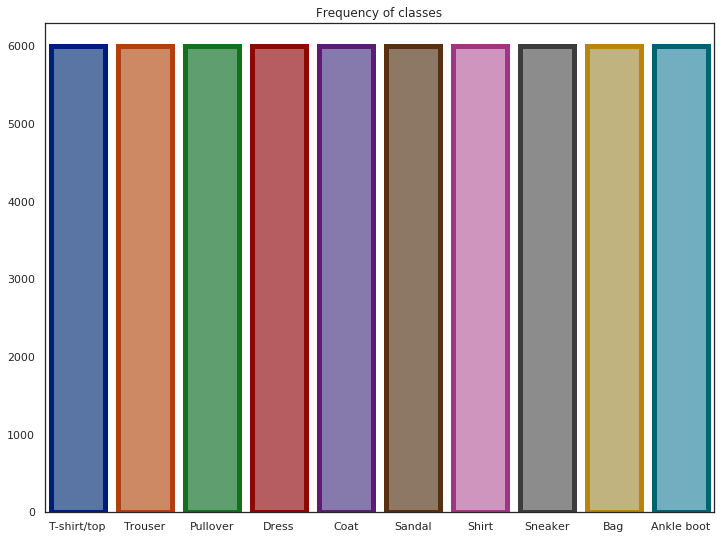

In [2]:
df = pd.read_csv('../input/fashion-mnist_train.csv')
Y = df['label'].values
X = df.drop('label', axis = 1).values.reshape(df.shape[0], 28, 28)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .25, random_state = 1)
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
fig = plt.figure(figsize=(12, 9))
sns.set_style("white")
ax = sns.barplot(x=classes, y=pd.value_counts(df['label'].values), linewidth=5,edgecolor=sns.color_palette("dark", 10))
plt.title("Frequency of classes")



# Data Loading in PyTorch
For those new to pytorch can head [here](https://www.kaggle.com/ankitjha/the-ultimate-pytorch-cookbook) for quick tutorial.
<br/>
*Just for a basic description*
<br/>
Data loading in PyTorch can be separated in 2 parts: 

* Data must be wrapped on a Dataset parent class where the methods getitem and len must be overrided. Not that, the data is not loaded on memory by now.
* The Dataloader reads the data and puts it into memory

#### torchvision
It is used to load and prepare dataset. Using it you can create transformations on the input data. 

#### transforms
It is used for preprocessing images and performing operations sequentially. 

#### num_workers
It is used for multiprocessing.Normally, $$num workers = 4 * (number of gpus)$$ works well.

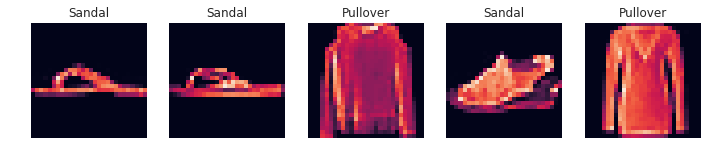

In [3]:
class DatasetProcessing(Dataset):
    def __init__(self, data, target, transform=None): #used to initialise the class variables - transform, data, target
        self.transform = transform
        self.data = data.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
        self.target = torch.from_numpy(target).long() # needs to be in torch.LongTensor dtype
    def __getitem__(self, index): #used to retrieve the X and y index value and return it
        return self.transform(self.data[index]), self.target[index]
    def __len__(self): #returns the length of the data
        return len(list(self.data))
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
dset_train = DatasetProcessing(X_train, y_train, transform)
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=32,
                                          shuffle=True, num_workers=4)
dset_test = DatasetProcessing(X_test, y_test, transform)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=32,
                                          shuffle=True, num_workers=4)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
fig = plt.figure(figsize=(12,6))
for num, x in enumerate(X_train[0:5]):
    plt.subplot(1,5,num+1)
    plt.axis('off')
    plt.imshow(x)
    plt.title(classes[y_train[num]])

# Architecture
<img src="https://cdn-images-1.medium.com/max/1600/1*IqMwp2BJzuviCuZ8r-pO6w.png" data-canonical-src="https://cdn-images-1.medium.com/max/1600/1*IqMwp2BJzuviCuZ8r-pO6w.png" width="700" height="700" />

The levels of Capsule network can be divided as follows:
* Level 1 :  **Input layer** <br/>
At this level, the input image is fed into the net.
* Level 2 : **CNN layer** <br/>
At this level,  *9 x 9 dim filter* are applied on entire image *stride of 2* and *256 layers* followed by relu activation function. The output dimension becomes ***20 x 20 x 256*** 
* Level 3 : **Primary Capsules** <br/>
The primary capsules represent entities of the lowest level. The primary capsules are connected to the digit capsules. Therefore the total capsule units are 32 * 6 * 6 with 6* 6 sharing the same weight vector $W_{ij}$ as shown in the above figure. Each capsule unit is an 8D vector.
* Level 4 : **Digit Capsules** <br/>
The Digit capsules represent entities of higher level and become active by agreement of primary capsules. *There are 10 caspsules in this layer each having 16 dimensions*.
<br/>

The  entire control flow take this form
![](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

where ***the encoder structure takes the image as an input and follows the above mentioned pipeline*** and  ***the decoder structure is used to construct the input image from the digit caps level***. This reconstruction of original image ensures that the model is not overfitted and thus acts as a **regularizer**.

# Routing By agreement

This is the pivotal part of capsule network
<br/>
Initially when the feature maps have been produced by the CNN layer, the capsules at the lower level try to predict the output of the capsules at the higher level. When the capsules at the lowel level come upon an agreement over the presence of an entity at higher level, the capsule corresponding to that entity becomes active. Hence, other capsules are rejected and this is instrumental in removing noise  from the model. Therefore, when there is a strong agreement between the capsules at the lower levels for the activity of the capsules at the higher level, the capsules at the lower level are **routed** to the capsules at higher level.


**Routing pseudocode**
( $\boldsymbol{\hat{\textbf{u}}}_{j|i}$ : *predictions made by i*, $r$ : *number of iterations*, $l$: *num_layer*)
>procedure( $\boldsymbol{\hat{\textbf{u}}}_{j|i}$, $r$, $l$)

> for all capsule $i$ in layer $l$ and capsule $j$ in layer $l+1$: $b_{ij} := 0$ 

> for $r$ iterations do:

>> for all capsules $i$ in the layer $l$: $c_{ij} = softmax(b_{ij})$            ->  **eqn {$i$}**
>>> ***This is the coupling coefficient found by calculating the probability of the routing weights of the layer.***

>>for all capsules $j$ in the layer $l+1$: $s_{ij} = \sum_{i=1}^{m}{c_{ij}\boldsymbol{\hat{\textbf{u}}}_{j|i}}$         ->  **eqn {$ii$}**
>>> ***This step calculates the weighted sum of all the predictions by layer $i$ for each capsule in layer j.***

>>for all capsules $j$ in the layer $l+1$: $\textbf{v}_j = \textbf{squash}(\textbf{s}_{ij})$
>>> ***This non-linear activation function known as squashing function makes the value in range {$0, 1$}.***        ->  **eqn {$iii$}**

>>for all capsule $i$ in layer $l$ and capsule $j$ in layer $l+1$: $b_{ij} = b_{ij} + \boldsymbol{\hat{\textbf{u}}}_{j|i} \cdot \textbf{v}_j$
>>>***This step is used to modify the routing weights according to the predictions made by capsules in layer $i$. ***     ->  **eqn {$iv$}**

>return $\textbf{v}_j$

Let us now implement this code step by step to get the intuition and understand it properly. Please fork this notebook if you want to execute the code below.

In [4]:
class CapsuleLevel(nn.Module):
    def __init__(self, in_channels, out_channels, capsule_dimension = 8, num_capsules = 10, num_capsule_units = 6 * 6 * 32, routing = False, iterations=3):
        super(CapsuleLevel, self).__init__()
        self.routing = routing
        self.iterations = iterations
        self.num_capsules = num_capsules
        self.num_capsule_units = num_capsule_units
        if routing == True:
            self.route_weights = nn.Parameter(torch.randn(num_capsule_units, num_capsules, out_channels, in_channels))
        else:
            self.capsules = nn.ModuleList(
                [nn.Conv2d(in_channels, out_channels, kernel_size=(9, 9), stride=(2, 2), padding=0) for _ in
                 range(capsule_dimension)])

            
    # The squash function
    def squash(self, s, dim=-1):
        norm = torch.sum(s**2, dim=dim, keepdim=True)
        return norm / (1 + norm) * s / (torch.sqrt(norm) + 1e-8)

    def forward(self, x):
        if self.routing == True:          # Routing by Agreement
            batch_size = x.size(0)
            
            route_weights = torch.stack([self.route_weights] * batch_size, dim = 0) #dim:([1152, 10, 16, 8])
            x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4) #dim:([128, 1152, 10, 8, 1])
            u_hat = torch.matmul(self.route_weights, x)  #dim:([128, 1152, 10, 16, 1])
            u_hat = u_hat.squeeze(-1)   #dim([128, 1152, 10, 16])
            temp_u_hat = u_hat.detach()
            
            #b_ij dim:([128, 1152, 10, 1])
            b_ij = Variable(torch.zeros(batch_size, self.num_capsule_units, self.num_capsules, 1).cuda()) 
            for iteration in range(self.iterations):
                c_ij = F.softmax(b_ij, dim=1)   # Equation 1 # c_ij dim:([128, 1152, 10, 1])
                s_ij = (c_ij * temp_u_hat).sum(dim=1)  # Equation 2 # s_ij dim:([128, 10, 16])
                temp_u_hat = temp_u_hat.unsqueeze(3)  # temp_u_hat dim:([128, 1152, 10, 16, 1])
                v_j = self.squash(s_ij, dim=2) # Equation 3  # v_j dim:([128, 10, 16])
                v_j_i = torch.stack([v_j] * self.num_capsule_units, dim = 1).unsqueeze(-1) # v_j_i dim:([128, 10, 16, 1])
                v_j_i = torch.matmul(temp_u_hat, v_j_i).squeeze(3)  
                temp_u_hat = temp_u_hat.squeeze(3)
                b_ij = b_ij + v_j_i # Equation 4
        else:
            v_j = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]   
            v_j = torch.cat(v_j, dim=-1)
            v_j = self.squash(v_j)

        return v_j

In [5]:
class CapsuleNetwork(nn.Module):  
    def __init__(self):
        super(CapsuleNetwork, self).__init__()
        self.batch_size = 32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(9, 9), stride=(1, 1), padding=0)
        self.primaryCaps = CapsuleLevel(in_channels=256, out_channels=32, capsule_dimension=8)
        self.digitCaps   = CapsuleLevel(in_channels=8, out_channels=16, num_capsules=10, routing=True)
        self.decoder     = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
    def forward(self, x, y=None):
        x = F.relu(self.conv1(x), inplace=True)
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        if y is None:
            # Get most active capsule
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.eye(10)).cuda().index_select(dim=0, index=Variable(max_length_indices.data))
        reconstructions = self.decoder((x * y[:, :, None]).view(x.size(0), -1))
        return classes, reconstructions

# Margin Loss for capsule networks

The loss function for capsule network is defined as

![](https://cdn-images-1.medium.com/max/1493/1*y-bVFuiLReqSSdmdZ6wAmA.png)

The loss function which is used for Capsule networks is **linear combination of margin loss function and reconstruction loss**. The first part of the margin loss is calculated for correct prediction i.e. it is 0 in case of output with > 0.9 probability, non-zero otherwise. The second part is calculated for incorrect prediction i.e. 0 when incorrect prediction with probability < 0.1 is prediction, non-zero otherwise. The reconstruction loss is the maximum likelihood estimation loss between the reconstruction of the image using encoder-decoder structure and the original image.

In [6]:
class LossFunction(nn.Module):
    def __init__(self):
        super(LossFunction, self).__init__()
        self.reconstruction_loss = nn.MSELoss(size_average=False)

    def forward(self, img, target, classes, reconstructions):
        fn_1 = F.relu(0.9 - classes, inplace=True) ** 2  # Calculated for correct digit cap
        fn_2 = F.relu(classes - 0.1, inplace=True) ** 2  # Calculated for incorrect digit cap
        margin_loss = target * fn_1 + 0.5 * (1. - target) * fn_2
        margin_loss = margin_loss.sum()
        img = img.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, img)
        return (margin_loss + 0.0005 * reconstruction_loss) / img.size(0)

# Training Capsule Network

In [7]:
train_loss = []
test_loss = []
def train(train_loader, epoch):
    global model
    model.train()
    if torch.cuda.is_available():
        model = model.cuda()
    tr_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = data.size(0)
        labels = target
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        capsule_loss = LossFunction()
        labels = torch.LongTensor(labels)
        labels = torch.eye(10).index_select(dim=0, index=labels)
        labels = Variable(labels).cuda()
        optimizer.zero_grad()
        classes, reconstructions = model(data, labels)
        loss = capsule_loss(data, labels, classes, reconstructions)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        pred = classes.data.max(1, keepdim=True)[1]
        if (batch_idx + 1)% 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
    train_loss.append(tr_loss / len(train_loader))

## Evaluating the training

In [8]:

def evaluate(data_loader):
    global model
    model.eval()
    loss = 0
    
    for data, target in data_loader:
        labels = target
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        labels = torch.LongTensor(labels)
        labels = torch.eye(10).index_select(dim=0, index=labels)
        labels = Variable(labels).cuda()
        classes, reconstructions = model(data)
        capsule_loss = LossFunction()
        loss += capsule_loss(data, labels, classes, reconstructions).item()
        pred = classes.data.max(1, keepdim=True)[1]
        
    loss /= len(data_loader.dataset)
    test_loss.append(loss)
    print('\nAverage Validation loss: {:.6f}\n'.format(loss))

**One limitation of capsule networks is that it takes a lot of time to train. Therefore, I have limited this kernel to 5 epochs so as to be in the kernel time limit. You can copy this code in your local system and run for many epochs. Thus the accuracy is  low initially but you will see better accuracy after 100 epochs. Note that this also depends on the learning rate and optimizer.**

Let's have a look at the parameters and shape of the layers.

In [9]:
summary(CapsuleNetwork().cuda(), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 20, 20]          20,992
            Conv2d-2             [-1, 32, 6, 6]         663,584
            Conv2d-3             [-1, 32, 6, 6]         663,584
            Conv2d-4             [-1, 32, 6, 6]         663,584
            Conv2d-5             [-1, 32, 6, 6]         663,584
            Conv2d-6             [-1, 32, 6, 6]         663,584
            Conv2d-7             [-1, 32, 6, 6]         663,584
            Conv2d-8             [-1, 32, 6, 6]         663,584
            Conv2d-9             [-1, 32, 6, 6]         663,584
     CapsuleLevel-10              [-1, 1152, 8]               0
     CapsuleLevel-11               [-1, 10, 16]               0
           Linear-12                  [-1, 512]          82,432
             ReLU-13                  [-1, 512]               0
           Linear-14                 [-

In [10]:
model = CapsuleNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epochs = 15
for epoch in range(n_epochs):
    train(train_loader, epoch)  #Training the model
    evaluate(test_loader)  #evaluating the model

Train Epoch: 0 [16000/45000 (36%)]	Loss: 0.938520
Train Epoch: 0 [32000/45000 (71%)]	Loss: 0.905805

Average Validation loss: 0.031000

Train Epoch: 1 [16000/45000 (36%)]	Loss: 0.871861
Train Epoch: 1 [32000/45000 (71%)]	Loss: 0.950709

Average Validation loss: 0.030744

Train Epoch: 2 [16000/45000 (36%)]	Loss: 0.924533
Train Epoch: 2 [32000/45000 (71%)]	Loss: 0.915380

Average Validation loss: 0.030808

Train Epoch: 3 [16000/45000 (36%)]	Loss: 0.900764
Train Epoch: 3 [32000/45000 (71%)]	Loss: 0.908912

Average Validation loss: 0.030660

Train Epoch: 4 [16000/45000 (36%)]	Loss: 0.930204
Train Epoch: 4 [32000/45000 (71%)]	Loss: 0.932167

Average Validation loss: 0.030570

Train Epoch: 5 [16000/45000 (36%)]	Loss: 0.935817
Train Epoch: 5 [32000/45000 (71%)]	Loss: 0.921407

Average Validation loss: 0.030621

Train Epoch: 6 [16000/45000 (36%)]	Loss: 0.907132
Train Epoch: 6 [32000/45000 (71%)]	Loss: 0.901967

Average Validation loss: 0.030614

Train Epoch: 7 [16000/45000 (36%)]	Loss: 0.91176

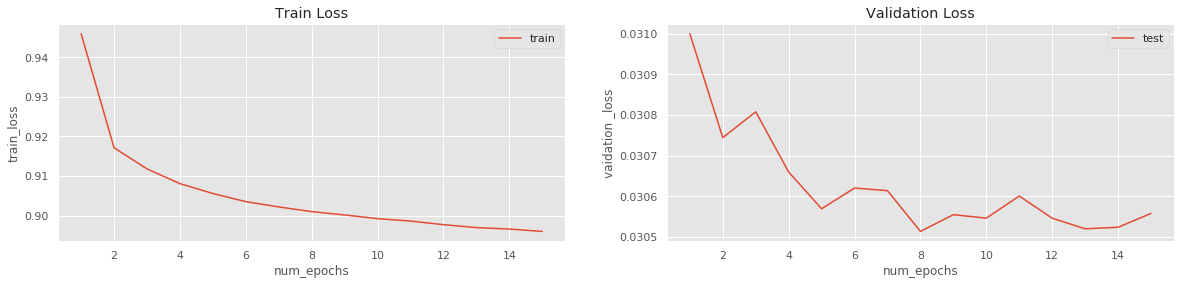

In [11]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1, 2, 1)
plt.title("Train Loss")
plt.plot(list(np.arange(15) + 1) , train_loss, label='train')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('train_loss', fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='best')
ax = fig.add_subplot(1, 2, 2)
plt.title("Validation Loss")
plt.plot(list(np.arange(15) + 1), test_loss, label='test')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('vaidation _loss', fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='best')

## References

* [Dynamic Routing between Capules](https://arxiv.org/pdf/1710.09829.pdf)
* [capsule-networks](https://github.com/gram-ai/capsule-networks)

* **Please upvote if you liked it and feel free to share your feedback**